In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
dates = pd.date_range(start='2024-01-01', periods=90, freq='D')

normal_data = {
    'date': dates,
    'total_transactions': np.random.normal(5000, 500, 90).astype(int),
    'avg_order_value': np.random.normal(75, 10, 90),
    'null_percentage': np.random.uniform(0.1, 2.0, 90),
    'processing_time_sec': np.random.normal(120, 15, 90),
    'unique_customers': np.random.normal(3500, 300, 90).astype(int)
}

In [3]:
df = pd.DataFrame(normal_data)

In [4]:
df.loc[30, 'total_transactions'] = 15000
df.loc[30, 'processing_time_sec'] = 450

df.loc[50, 'null_percentage'] = 25.0
df.loc[50, 'unique_customers'] = 500

df.loc[70, 'avg_order_value'] = 5.0

In [5]:
print("ETL DATA QUALITY MONITORING WITH ISOLATION FOREST")
print("=" * 60)
print(f"Dataset: {len(df)} days of sales data")
print(f"Injected anomalies on days: 30, 50, 70\n")

ETL DATA QUALITY MONITORING WITH ISOLATION FOREST
Dataset: 90 days of sales data
Injected anomalies on days: 30, 50, 70



In [6]:
features = ['total_transactions', 'avg_order_value', 'null_percentage', 
            'processing_time_sec', 'unique_customers']

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

iso_forest = IsolationForest(
    contamination=0.05,
    random_state=42,
    n_estimators=100
)

In [8]:
df['anomaly'] = iso_forest.fit_predict(X_scaled)
df['anomaly_score'] = iso_forest.score_samples(X_scaled)

anomalies = df[df['anomaly'] == -1]

In [9]:
print("DETECTED ANOMALIES:")
print("-" * 60)
for idx, row in anomalies.iterrows():
    print(f"\nDate: {row['date'].strftime('%Y-%m-%d')} (Day {idx})")
    print(f"   Anomaly Score: {row['anomaly_score']:.3f}")
    print(f"   Transactions: {row['total_transactions']:,}")
    print(f"   Avg Order Value: ${row['avg_order_value']:.2f}")
    print(f"   Null %: {row['null_percentage']:.2f}%")
    print(f"   Processing Time: {row['processing_time_sec']:.1f}s")
    print(f"   Unique Customers: {row['unique_customers']:,}")

print("\n" + "=" * 60)
print("ALERT RECOMMENDATIONS:")
print("=" * 60)

DETECTED ANOMALIES:
------------------------------------------------------------

Date: 2024-01-11 (Day 10)
   Anomaly Score: -0.536
   Transactions: 4,768
   Avg Order Value: $60.85
   Null %: 0.13%
   Processing Time: 71.4s
   Unique Customers: 3,757

Date: 2024-01-31 (Day 30)
   Anomaly Score: -0.769
   Transactions: 15,000
   Avg Order Value: $82.91
   Null %: 1.77%
   Processing Time: 450.0s
   Unique Customers: 3,935

Date: 2024-02-20 (Day 50)
   Anomaly Score: -0.740
   Transactions: 5,162
   Avg Order Value: $77.27
   Null %: 25.00%
   Processing Time: 131.2s
   Unique Customers: 500

Date: 2024-03-11 (Day 70)
   Anomaly Score: -0.577
   Transactions: 5,180
   Avg Order Value: $5.00
   Null %: 1.48%
   Processing Time: 107.7s
   Unique Customers: 3,039

Date: 2024-03-15 (Day 74)
   Anomaly Score: -0.516
   Transactions: 3,690
   Avg Order Value: $84.63
   Null %: 1.61%
   Processing Time: 137.4s
   Unique Customers: 3,965

ALERT RECOMMENDATIONS:


In [10]:
for idx, row in anomalies.iterrows():
    alerts = []
    
    if row['total_transactions'] > df['total_transactions'].mean() + 2*df['total_transactions'].std():
        alerts.append("HIGH: Transaction volume spike")
    
    if row['null_percentage'] > 10:
        alerts.append("CRITICAL: High null rate - data pipeline issue")
    
    if row['avg_order_value'] < 20:
        alerts.append("MEDIUM: Unusually low order values")
    
    if row['processing_time_sec'] > 300:
        alerts.append("HIGH: ETL processing delay")
    
    if alerts:
        print(f"\nDay {idx}:")
        for alert in alerts:
            print(f"  {alert}")

print("\n" + "=" * 60)
print("SUMMARY:")
print("=" * 60)
print(f"Total records analyzed: {len(df)}")
print(f"Anomalies detected: {len(anomalies)}")
print(f"Detection rate: {len(anomalies)/len(df)*100:.1f}%")
print(f"\nNormal ranges (mean ± 2σ):")
print(f"  Transactions: {df['total_transactions'].mean():.0f} ± {2*df['total_transactions'].std():.0f}")
print(f"  Order Value: ${df['avg_order_value'].mean():.2f} ± ${2*df['avg_order_value'].std():.2f}")
print(f"  Null Rate: {df['null_percentage'].mean():.2f}% ± {2*df['null_percentage'].std():.2f}%")


Day 30:
  HIGH: Transaction volume spike
  HIGH: ETL processing delay

Day 50:
  CRITICAL: High null rate - data pipeline issue

Day 70:
  MEDIUM: Unusually low order values

SUMMARY:
Total records analyzed: 90
Anomalies detected: 5
Detection rate: 5.6%

Normal ranges (mean ± 2σ):
  Transactions: 5065 ± 2315
  Order Value: $74.88 ± $24.27
  Null Rate: 1.36% ± 5.16%



Visualization saved as 'anomaly_detection_results.png'

Monitoring complete!


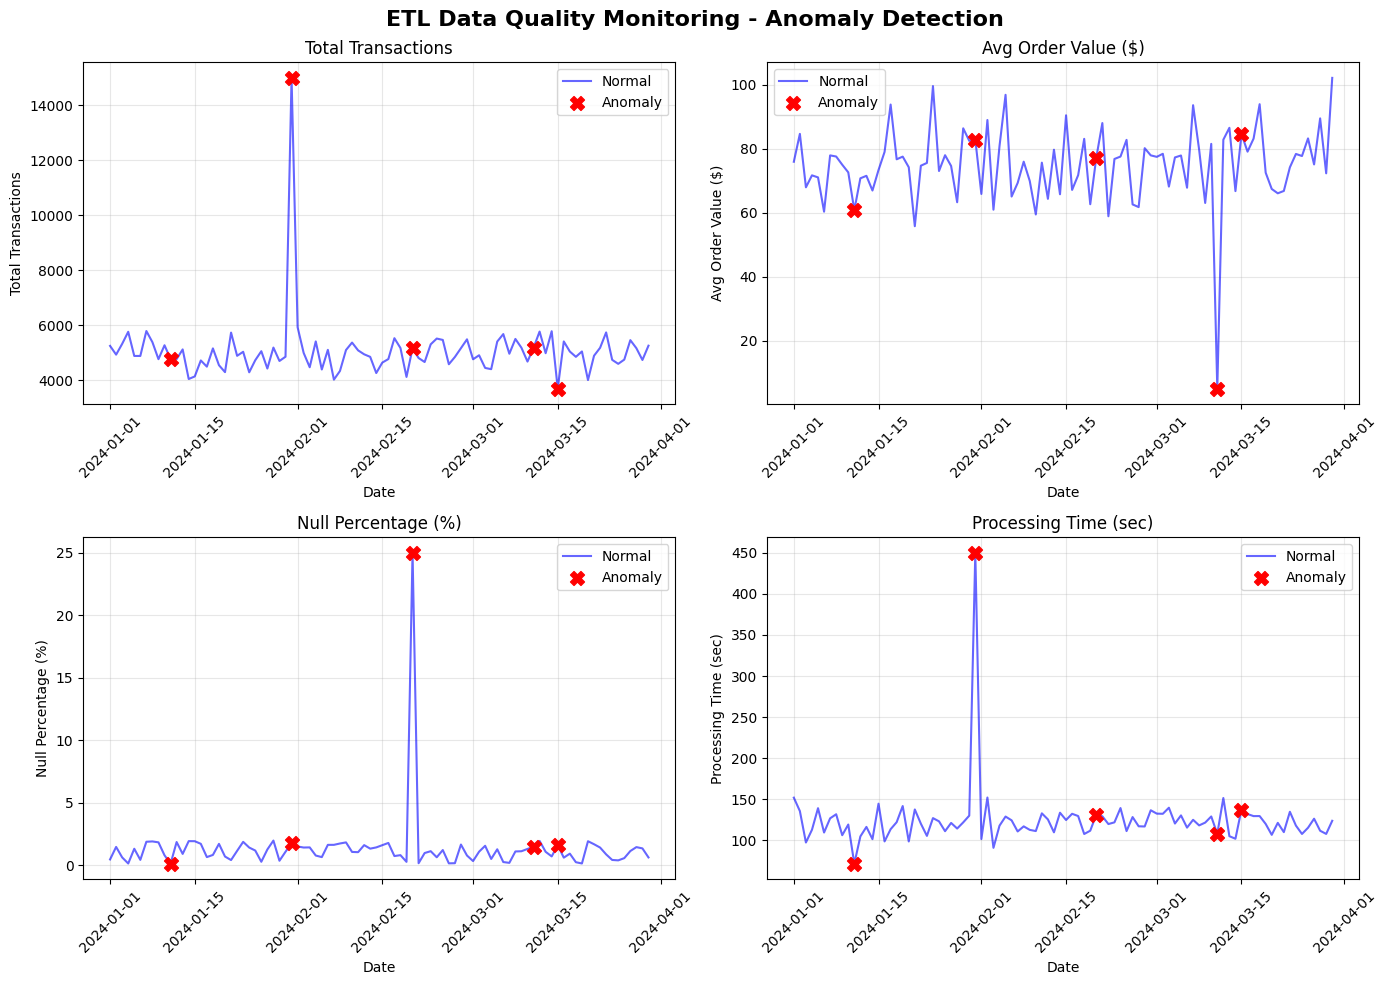

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ETL Data Quality Monitoring - Anomaly Detection', fontsize=16, fontweight='bold')

metrics = [
    ('total_transactions', 'Total Transactions', axes[0, 0]),
    ('avg_order_value', 'Avg Order Value ($)', axes[0, 1]),
    ('null_percentage', 'Null Percentage (%)', axes[1, 0]),
    ('processing_time_sec', 'Processing Time (sec)', axes[1, 1])
]

for metric, label, ax in metrics:
    ax.plot(df['date'], df[metric], 'b-', alpha=0.6, label='Normal')
    ax.scatter(anomalies['date'], anomalies[metric], 
               color='red', s=100, zorder=5, label='Anomaly', marker='X')
    ax.set_xlabel('Date')
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('anomaly_detection_results.png', dpi=300, bbox_inches='tight')
print(f"\nVisualization saved as 'anomaly_detection_results.png'")
print("\nMonitoring complete!")